# Applying various Regression Model

###  The model uses lableencoding , XGboost , lightgbm
## Please install  xgboost from PIP 


In [1]:
import numpy as np
import pandas as pd
import glob
import os
import pickle
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## DATA

In this case we are reading used cars data.  With this data we are trying to predict the selling price of car in pounds

#### The features are:
- Model and make of the car 
- Purchase year of the car
- Transmission
- Mileage
- FuelType
- MPG
- EngineSize


In [2]:
path = 'https://data-bootcamp-rice-009.s3.us-east-2.amazonaws.com/' # use your s3 bucket path

li = []
brands = ["Audi","BMW","Ford","Hyundi","Mercedes Benz","Skoda","Toyota","Volkswagen"]
csv_names = ["audi", "bmw", "ford", "hyundi", "merc", "skoda","toyota", "vw"]

for i in range(0,8):
    filename = path + csv_names[i] + ".csv"
    print(filename)
    frame = pd.read_csv(filename, index_col=None, header=0)
    frame["make"] = brands[i]
    li.append(frame)
    
concat_usedcars = pd.concat(li, axis=0, ignore_index=True)
concat_usedcars


https://data-bootcamp-rice-009.s3.us-east-2.amazonaws.com/audi.csv
https://data-bootcamp-rice-009.s3.us-east-2.amazonaws.com/bmw.csv
https://data-bootcamp-rice-009.s3.us-east-2.amazonaws.com/ford.csv
https://data-bootcamp-rice-009.s3.us-east-2.amazonaws.com/hyundi.csv
https://data-bootcamp-rice-009.s3.us-east-2.amazonaws.com/merc.csv
https://data-bootcamp-rice-009.s3.us-east-2.amazonaws.com/skoda.csv
https://data-bootcamp-rice-009.s3.us-east-2.amazonaws.com/toyota.csv
https://data-bootcamp-rice-009.s3.us-east-2.amazonaws.com/vw.csv


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,make
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,Audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,Audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,Audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,Audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,Audi
...,...,...,...,...,...,...,...,...,...,...
85550,Eos,2012,5990,Manual,74000,Diesel,125,58.9,2.0,Volkswagen
85551,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2,Volkswagen
85552,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4,Volkswagen
85553,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2,Volkswagen


In [4]:
usedcars_df = concat_usedcars.loc[concat_usedcars['year'] != 2060]

In [5]:
# remove unwanted feature
usedcars_df =usedcars_df.drop("tax", axis=1)
usedcars_df['year'] = usedcars_df['year'].astype(str)
usedcars_df['model'] = usedcars_df['model'].str.strip()

In [6]:
del concat_usedcars

In [7]:
# identified outliers from Tableau
index_list = [9434,10109,7221,7845,17753,14988,14306,33361,22488,43661,44279,62386]

In [8]:
#outliers
Filter_df  = usedcars_df[usedcars_df.index.isin(index_list)]
Filter_df

,model,year,price,transmission,mileage,fuelType,mpg,engineSize,make
7221,A5,2020,59995,Semi-Auto,2000,Diesel,40.9,3.0,Audi
7845,A6,2018,59950,Automatic,22000,Petrol,29.4,4.0,Audi
9434,A8,2020,78990,Automatic,250,Diesel,39.2,3.0,Audi
10109,S3,2003,4990,Manual,106000,Petrol,39.8,1.8,Audi
14306,2 Series,2015,123456,Semi-Auto,33419,Diesel,68.9,2.0,BMW
14988,5 Series,2020,54845,Semi-Auto,450,Diesel,60.1,3.0,BMW
17753,3 Series,2020,71990,Semi-Auto,150,Diesel,47.1,3.0,BMW
22488,Focus,2017,38015,Manual,197,Diesel,74.3,1.5,Ford
33361,Focus,2018,54995,Manual,11000,Petrol,36.7,2.3,Ford
43661,I10,2017,92000,Automatic,35460,Petrol,47.9,1.2,Hyundi


In [9]:
#remove outliers
usedcars_df = usedcars_df.drop(index_list)

In [10]:
usedcars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85542 entries, 0 to 85554
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         85542 non-null  object 
 1   year          85542 non-null  object 
 2   price         85542 non-null  int64  
 3   transmission  85542 non-null  object 
 4   mileage       85542 non-null  int64  
 5   fuelType      85542 non-null  object 
 6   mpg           85542 non-null  float64
 7   engineSize    85542 non-null  float64
 8   make          85542 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 6.5+ MB


In [11]:
usedcars_df.head()

,model,year,price,transmission,mileage,fuelType,mpg,engineSize,make
0,A1,2017,12500,Manual,15735,Petrol,55.4,1.4,Audi
1,A6,2016,16500,Automatic,36203,Diesel,64.2,2.0,Audi
2,A1,2016,11000,Manual,29946,Petrol,55.4,1.4,Audi
3,A4,2017,16800,Automatic,25952,Diesel,67.3,2.0,Audi
4,A3,2019,17300,Manual,1998,Petrol,49.6,1.0,Audi


## Preliminary Data Analysis

In [12]:
usedcars_df.isnull().sum(axis=0)

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
make            0
dtype: int64

## Train Test Split

In [13]:
# Assign X (data) and y (target)
X = usedcars_df.drop("price", axis=1)
y = usedcars_df["price"]
print(X.shape, y.shape)

(85542, 8) (85542,)


In [14]:
# split to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
del usedcars_df

## Create Pipeline

In [16]:
cat_cols = X.columns[X.dtypes == 'O']
num_cols = X.columns[X.dtypes == 'float64']

In [17]:
cat_cols

Index(['model', 'year', 'transmission', 'fuelType', 'make'], dtype='object')

In [18]:
categories = [
    X[column].unique() for column in X[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

In [19]:
categories

[array(['A1', 'A6', 'A4', 'A3', 'Q3', 'Q5', 'A5', 'S4', 'Q2', 'A7', 'TT',
        'Q7', 'RS6', 'RS3', 'A8', 'Q8', 'RS4', 'RS5', 'R8', 'SQ5', 'S8',
        'SQ7', 'S3', 'S5', 'A2', 'RS7', '5 Series', '6 Series', '1 Series',
        '7 Series', '2 Series', '4 Series', 'X3', '3 Series', 'X5', 'X4',
        'i3', 'X1', 'M4', 'X2', 'X6', '8 Series', 'Z4', 'X7', 'M5', 'i8',
        'M2', 'M3', 'M6', 'Z3', 'Fiesta', 'Focus', 'Puma', 'Kuga',
        'EcoSport', 'C-MAX', 'Mondeo', 'Ka+', 'Tourneo Custom', 'S-MAX',
        'B-MAX', 'Edge', 'Tourneo Connect', 'Grand C-MAX', 'KA', 'Galaxy',
        'Mustang', 'Grand Tourneo Connect', 'Fusion', 'Ranger', 'Streetka',
        'Escort', 'Transit Tourneo', 'I20', 'Tucson', 'I10', 'IX35', 'I30',
        'I40', 'Ioniq', 'Kona', 'Veloster', 'I800', 'IX20', 'Santa Fe',
        'Accent', 'Terracan', 'Getz', 'Amica', 'SLK', 'S Class',
        'SL CLASS', 'G Class', 'GLE Class', 'GLA Class', 'A Class',
        'B Class', 'GLC Class', 'C Class', 'E Class', 'GL

In [20]:
cat_proc_lin = make_pipeline(
    SimpleImputer(missing_values=None,
                  strategy='constant',
                  fill_value='missing'),
    OneHotEncoder(categories=categories)
)

num_proc_lin = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
# transformation to use for linear estimators
processor_lin = make_column_transformer(
    (cat_proc_lin, cat_cols),
    (num_proc_lin, num_cols),
    remainder='passthrough')

In [21]:
del cat_cols, num_cols, categories

## EVALUATE FUNCTION

A single function that will evaluate all models 

This will allow us to easily pick out the model we want to move forward with.

This function takes in a model ( pipeline ) and our train test split data. From there it simply performes predictions and generates results

In [22]:
def evaluate(pipeline, X_train, X_test, y_train, y_test):
    '''
    Evaluate a pipeline on training and test datasets
    '''    
    pipeline.fit(X_train, y_train)
    
    test_acc = pipeline.score(X_test, y_test)

    print(f"========== Predictor: {type(pipeline).__name__} ==========")
    print(f"Test result: f1: , acc: {test_acc:.3f}")
    print()


## Pick A Model For A Base Point To Evaluate Other Models Against

In this case we are choosing Logistric Regression

In [23]:
# try XGBRegressor
# evaluate(XGBRegressor(n_jobs=-1), X_train, X_test, y_train, y_test)
XGBrf = Pipeline(steps=[
    ('preprocess', processor_lin),
    ('regressor',XGBRegressor(n_jobs=-1))
])
evaluate(XGBrf, X_train, X_test, y_train, y_test)

========== Predictor: Pipeline ==========
Test result: f1: , acc: 0.954



In [24]:
LGBrf =  Pipeline(steps=[
    ('preprocess', processor_lin),
    ('regressor',LGBMRegressor(n_jobs=-1))
])

evaluate(LGBrf, X_train, X_test, y_train, y_test)


========== Predictor: Pipeline ==========
Test result: f1: , acc: 0.944



In [25]:
rf =  Pipeline(steps=[
    ('preprocess', processor_lin),
    ('regressor',RandomForestRegressor(n_estimators=140, min_samples_split=5, min_samples_leaf=4, max_features="sqrt", max_depth=20,bootstrap=False))
])
evaluate(rf, X_train, X_test, y_train, y_test)


========== Predictor: Pipeline ==========
Test result: f1: , acc: 0.898



In [26]:
GBrf =  Pipeline(steps=[
    ('preprocess', processor_lin),
    ('regressor',GradientBoostingRegressor())
])
evaluate(GBrf, X_train, X_test, y_train, y_test)

========== Predictor: Pipeline ==========
Test result: f1: , acc: 0.890



## Tuning final model and finding the best parameters for the model

The RandomizedSearchCV function will try all our combinations above and select the most accurate model.  

That best model is found in the best_estimator_ property of the RandomizedSerachCV object. 

In [27]:
XGBF = XGBRegressor(n_jobs=-1)
clf = Pipeline(steps=[
    ('preprocess', processor_lin),
    ('regressor',XGBF)
])
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 40, num = 5)]
max_depth = [int(x) for x in np.linspace(2, 18, num = 10)]
max_depth.append(None)
gbm_param_grid = {
    'regressor__colsample_bytree': [0.3, 0.7],
    'regressor__n_estimators': n_estimators,
    'regressor__max_depth': max_depth
}

clf2 = GridSearchCV(estimator=clf, param_grid=gbm_param_grid, cv=4, verbose=3)

In [28]:
clf2.fit(X_train, y_train)


Fitting 4 folds for each of 110 candidates, totalling 440 fits
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=20, score=0.813, total=   0.6s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=20 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=20, score=0.822, total=   0.6s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=20 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=20, score=0.826, total=   0.6s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=20, score=0.816, total=   0.6s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=25, score=0.824, total=   0.6s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=25, score=0.835, total=   0.6s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=2, regressor__n_estimators=25, score=0.837, total=   0.6s
[CV] regressor__colsample_bytree=0.3, regressor__m

[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=5, regressor__n_estimators=20, score=0.903, total=   0.7s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=5, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=5, regressor__n_estimators=20, score=0.899, total=   0.7s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=5, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=5, regressor__n_estimators=25, score=0.908, total=   0.7s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=5, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=5, regressor__n_estimators=25, score=0.912, total=   0.8s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=5, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=5, regressor__n_estimators=25, score=0.910, total=   0.8s
[CV] regressor__colsample_bytree=0.3, regressor__m

[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=9, regressor__n_estimators=20, score=0.940, total=   0.9s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=9, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=9, regressor__n_estimators=20, score=0.935, total=   0.8s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=9, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=9, regressor__n_estimators=25, score=0.936, total=   0.9s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=9, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=9, regressor__n_estimators=25, score=0.940, total=   0.9s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=9, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=9, regressor__n_estimators=25, score=0.943, total=   0.9s
[CV] regressor__colsample_bytree=0.3, regressor__m

[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=12, regressor__n_estimators=20, score=0.948, total=   1.0s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=12, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=12, regressor__n_estimators=20, score=0.944, total=   1.0s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=12, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=12, regressor__n_estimators=25, score=0.946, total=   1.0s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=12, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=12, regressor__n_estimators=25, score=0.944, total=   1.1s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=12, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=12, regressor__n_estimators=25, score=0.951, total=   1.0s
[CV] regressor__colsample_bytree=0.3, reg

[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=16, regressor__n_estimators=20, score=0.953, total=   1.1s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=16, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=16, regressor__n_estimators=20, score=0.948, total=   1.1s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=16, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=16, regressor__n_estimators=25, score=0.951, total=   1.2s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=16, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=16, regressor__n_estimators=25, score=0.948, total=   1.2s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=16, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=16, regressor__n_estimators=25, score=0.956, total=   1.2s
[CV] regressor__colsample_bytree=0.3, reg

[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=None, regressor__n_estimators=20, score=0.921, total=   0.7s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=None, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=None, regressor__n_estimators=20, score=0.919, total=   0.8s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=None, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=None, regressor__n_estimators=20, score=0.915, total=   0.7s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=None, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=None, regressor__n_estimators=25, score=0.918, total=   0.8s
[CV] regressor__colsample_bytree=0.3, regressor__max_depth=None, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.3, regressor__max_depth=None, regressor__n_estimators=25, score=0.926, total=   0.8s
[CV] regressor__colsamp

[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=3, regressor__n_estimators=20, score=0.854, total=   0.7s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=3, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=3, regressor__n_estimators=20, score=0.869, total=   0.7s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=3, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=3, regressor__n_estimators=20, score=0.865, total=   0.7s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=3, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=3, regressor__n_estimators=20, score=0.859, total=   0.7s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=3, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=3, regressor__n_estimators=25, score=0.864, total=   0.7s
[CV] regressor__colsample_bytree=0.7, regressor__m

[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=7, regressor__n_estimators=20, score=0.930, total=   0.9s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=7, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=7, regressor__n_estimators=20, score=0.938, total=   0.9s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=7, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=7, regressor__n_estimators=20, score=0.936, total=   0.9s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=7, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=7, regressor__n_estimators=20, score=0.932, total=   0.9s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=7, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=7, regressor__n_estimators=25, score=0.933, total=   1.0s
[CV] regressor__colsample_bytree=0.7, regressor__m

[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=10, regressor__n_estimators=20, score=0.948, total=   1.1s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=10, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=10, regressor__n_estimators=20, score=0.952, total=   1.1s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=10, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=10, regressor__n_estimators=20, score=0.954, total=   1.1s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=10, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=10, regressor__n_estimators=20, score=0.951, total=   1.1s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=10, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=10, regressor__n_estimators=25, score=0.949, total=   1.2s
[CV] regressor__colsample_bytree=0.7, reg

[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=14, regressor__n_estimators=20, score=0.955, total=   1.3s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=14, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=14, regressor__n_estimators=20, score=0.958, total=   1.3s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=14, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=14, regressor__n_estimators=20, score=0.962, total=   1.3s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=14, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=14, regressor__n_estimators=20, score=0.957, total=   1.3s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=14, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=14, regressor__n_estimators=25, score=0.956, total=   1.5s
[CV] regressor__colsample_bytree=0.7, reg

[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=18, regressor__n_estimators=20, score=0.958, total=   1.6s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=18, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=18, regressor__n_estimators=20, score=0.960, total=   1.6s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=18, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=18, regressor__n_estimators=20, score=0.963, total=   1.6s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=18, regressor__n_estimators=20 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=18, regressor__n_estimators=20, score=0.959, total=   1.6s
[CV] regressor__colsample_bytree=0.7, regressor__max_depth=18, regressor__n_estimators=25 
[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=18, regressor__n_estimators=25, score=0.959, total=   1.8s
[CV] regressor__colsample_bytree=0.7, reg

[CV]  regressor__colsample_bytree=0.7, regressor__max_depth=None, regressor__n_estimators=40, score=0.935, total=   1.3s


[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:  8.6min finished


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        missing_values=None,
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(categories=[array(['A1', 'A6', 'A4', 'A3', 'Q3', 'Q5', 'A5', 

In [29]:
# Print the best parameters and lowest RMSE
print("Best parameters found: ", clf2.best_params_)
print("Best Score found: ", np.sqrt(np.abs(clf2.best_score_)))

Best parameters found:  {'regressor__colsample_bytree': 0.7, 'regressor__max_depth': 18, 'regressor__n_estimators': 40}
Best Score found:  0.9802816869752399


In [30]:
best_random = clf2.best_estimator_
predictions = best_random.predict(X_test)
errors = abs(predictions - y_test)
mape = 100 * np.mean(errors / y_test)
accuracy = 100 - mape
print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))
clf2.best_params_
    

Model Performance
Average Error: 1200.2804 degrees.
Accuracy = 92.54%.


{'regressor__colsample_bytree': 0.7,
 'regressor__max_depth': 18,
 'regressor__n_estimators': 40}

In [31]:
## Using RandomizedSearchCV for best score

XGBF = XGBRegressor(n_jobs=-1)
clf = Pipeline(steps=[
    ('preprocess', processor_lin),
    ('regressor',XGBF)
])
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 150, num = 15)]
max_depth = [int(x) for x in np.linspace(2, 30, num = 20)]
max_depth.append(None)
gbm_param_grid = {
    'regressor__colsample_bytree': [0.3, 0.7],
    'regressor__n_estimators': n_estimators,
    'regressor__max_depth': max_depth
}

randomized_acc = RandomizedSearchCV(param_distributions=gbm_param_grid, estimator=clf, n_iter=20, cv=4, verbose=3)

# Fit randomized_mse to the data
randomized_acc.fit(X_train, y_train)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_acc.best_params_)
print("Best Score found: ", np.sqrt(np.abs(randomized_acc.best_score_)))

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] regressor__n_estimators=29, regressor__max_depth=22, regressor__colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  regressor__n_estimators=29, regressor__max_depth=22, regressor__colsample_bytree=0.7, score=0.959, total=   2.7s
[CV] regressor__n_estimators=29, regressor__max_depth=22, regressor__colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  regressor__n_estimators=29, regressor__max_depth=22, regressor__colsample_bytree=0.7, score=0.960, total=   2.6s
[CV] regressor__n_estimators=29, regressor__max_depth=22, regressor__colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV]  regressor__n_estimators=29, regressor__max_depth=22, regressor__colsample_bytree=0.7, score=0.963, total=   2.7s
[CV] regressor__n_estimators=29, regressor__max_depth=22, regressor__colsample_bytree=0.7 
[CV]  regressor__n_estimators=29, regressor__max_depth=22, regressor__colsample_bytree=0.7, score=0.959, total=   2.7s
[CV] regressor__n_estimators=103, regressor__max_depth=19, regressor__colsample_bytree=0.3 
[CV]  regressor__n_estimators=103, regressor__max_depth=19, regressor__colsample_bytree=0.3, score=0.958, total=   4.6s
[CV] regressor__n_estimators=103, regressor__max_depth=19, regressor__colsample_bytree=0.3 
[CV]  regressor__n_estimators=103, regressor__max_depth=19, regressor__colsample_bytree=0.3, score=0.956, total=   4.5s
[CV] regressor__n_estimators=103, regressor__max_depth=19, regressor__colsample_bytree=0.3 
[CV]  regressor__n_estimators=103, regressor__max_depth=19, regressor__colsample_bytree=0.3, score=0.962, total=   4.9s
[CV] regressor__n_estimators=103, r

[CV]  regressor__n_estimators=75, regressor__max_depth=9, regressor__colsample_bytree=0.3, score=0.954, total=   1.7s
[CV] regressor__n_estimators=75, regressor__max_depth=9, regressor__colsample_bytree=0.3 
[CV]  regressor__n_estimators=75, regressor__max_depth=9, regressor__colsample_bytree=0.3, score=0.957, total=   1.7s
[CV] regressor__n_estimators=75, regressor__max_depth=9, regressor__colsample_bytree=0.3 
[CV]  regressor__n_estimators=75, regressor__max_depth=9, regressor__colsample_bytree=0.3, score=0.953, total=   1.7s
[CV] regressor__n_estimators=103, regressor__max_depth=13, regressor__colsample_bytree=0.3 
[CV]  regressor__n_estimators=103, regressor__max_depth=13, regressor__colsample_bytree=0.3, score=0.960, total=   3.0s
[CV] regressor__n_estimators=103, regressor__max_depth=13, regressor__colsample_bytree=0.3 
[CV]  regressor__n_estimators=103, regressor__max_depth=13, regressor__colsample_bytree=0.3, score=0.957, total=   3.0s
[CV] regressor__n_estimators=103, regresso

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.6min finished


Best parameters found:  {'regressor__n_estimators': 112, 'regressor__max_depth': 18, 'regressor__colsample_bytree': 0.7}
Best Score found:  0.9802749984474335


In [32]:
## Using RandomizedSearchCV for mean squared error

XGBF = XGBRegressor(n_jobs=-1)
clf = Pipeline(steps=[
    ('preprocess', processor_lin),
    ('regressor',XGBF)
])
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 150, num = 15)]
max_depth = [int(x) for x in np.linspace(2, 30, num = 20)]
max_depth.append(None)
gbm_param_grid = {
    'regressor__colsample_bytree': [0.3, 0.7],
    'regressor__n_estimators': n_estimators,
    'regressor__max_depth': max_depth
}
randomized_mse = RandomizedSearchCV(param_distributions=gbm_param_grid, estimator=clf, scoring="neg_mean_squared_error", n_iter=5, cv=4, verbose=3)
# Fit randomized_mse to the data
randomized_mse.fit(X_train, y_train)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] regressor__n_estimators=94, regressor__max_depth=30, regressor__colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  regressor__n_estimators=94, regressor__max_depth=30, regressor__colsample_bytree=0.3, score=-4715940.963, total=   6.5s
[CV] regressor__n_estimators=94, regressor__max_depth=30, regressor__colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV]  regressor__n_estimators=94, regressor__max_depth=30, regressor__colsample_bytree=0.3, score=-5416498.489, total=   6.5s
[CV] regressor__n_estimators=94, regressor__max_depth=30, regressor__colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.9s remaining:    0.0s


[CV]  regressor__n_estimators=94, regressor__max_depth=30, regressor__colsample_bytree=0.3, score=-4205850.952, total=   6.4s
[CV] regressor__n_estimators=94, regressor__max_depth=30, regressor__colsample_bytree=0.3 
[CV]  regressor__n_estimators=94, regressor__max_depth=30, regressor__colsample_bytree=0.3, score=-4714448.545, total=   6.4s
[CV] regressor__n_estimators=47, regressor__max_depth=22, regressor__colsample_bytree=0.7 
[CV]  regressor__n_estimators=47, regressor__max_depth=22, regressor__colsample_bytree=0.7, score=-4136657.568, total=   3.6s
[CV] regressor__n_estimators=47, regressor__max_depth=22, regressor__colsample_bytree=0.7 
[CV]  regressor__n_estimators=47, regressor__max_depth=22, regressor__colsample_bytree=0.7, score=-4328156.892, total=   3.6s
[CV] regressor__n_estimators=47, regressor__max_depth=22, regressor__colsample_bytree=0.7 
[CV]  regressor__n_estimators=47, regressor__max_depth=22, regressor__colsample_bytree=0.7, score=-3660955.940, total=   3.6s
[CV] r

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


Best parameters found:  {'regressor__n_estimators': 29, 'regressor__max_depth': 22, 'regressor__colsample_bytree': 0.7}
Lowest RMSE found:  2016.0730660913225


# Evaluate Our Model Further

Now we are going to shuffle the data over and over and apply our new model to the results to further determine if we want to use this model.

In [33]:
# evaluate model with kfold
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(randomized_mse.best_estimator_, X, y, cv=kfold, n_jobs=-1)
print("Results: %.2f (%.2f) accuracy" % (results.mean(), results.std()))

Results: 0.97 (0.00) accuracy


In [34]:
# evaluate model with kfold
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(randomized_acc.best_estimator_, X, y, cv=kfold, n_jobs=-1)
print("Results: %.2f (%.2f) accuracy" % (results.mean(), results.std()))

Results: 0.96 (0.00) accuracy


In [35]:
# evaluate model with kfold
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(clf2.best_estimator_, X, y, cv=kfold, n_jobs=-1)
print("Results: %.2f (%.2f) accuracy" % (results.mean(), results.std()))

Results: 0.97 (0.00) accuracy


## Save The Model For Future Use

In [36]:
# save model
with open(f'best_xgb_pipeline_model.pickle', 'wb') as f:
    pickle.dump(randomized_mse.best_estimator_, f)

In [37]:
# save model
with open(f'best_xgb_pipeline_model_acc.pickle', 'wb') as f:
    pickle.dump(randomized_acc.best_estimator_, f)

In [38]:
# save model
with open(f'best_xgb_pipeline_model_GS.pickle', 'wb') as f:
    pickle.dump(clf2.best_estimator_, f)

## Test the model

In [39]:
import pickle
import numpy as np

In [40]:
file = open("best_xgb_pipeline_model.pickle",'rb')
le_loaded = pickle.load(file)
file.close()

In [41]:
values = ['Fox',2008,'Manual', 88102,'Petrol',46.3,1.2,'Volkswagen']


In [42]:
features = [np.array(values)]

In [43]:
df = pd.DataFrame(features,columns=['model','year','transmission','mileage','fuelType','mpg','engineSize','make'])
df

,model,year,transmission,mileage,fuelType,mpg,engineSize,make
0,Fox,2008,Manual,88102,Petrol,46.3,1.2,Volkswagen


In [44]:
le_loaded.predict(df)

array([1995.9774], dtype=float32)

In [45]:
df_deploy = pd.DataFrame(features,columns=['model','year','transmission','mileage','fuelType','mpg','engineSize','make'])
df_deploy

,model,year,transmission,mileage,fuelType,mpg,engineSize,make
0,Fox,2008,Manual,88102,Petrol,46.3,1.2,Volkswagen


In [46]:
randomized_mse.predict(df_deploy)

array([1995.9774], dtype=float32)

In [47]:
predictions = randomized_mse.predict(X_test[:30])

In [48]:
predictions

array([ 6277.4673,  3568.9392, 12538.411 , 12984.512 , 13254.391 ,
       23126.277 , 18822.95  , 18927.7   , 18156.87  ,  7882.718 ,
       20157.346 , 25636.271 , 54538.598 ,  2457.6235, 13773.6   ,
       10684.449 , 19216.012 , 15709.079 , 27821.5   , 34616.484 ,
       11498.328 , 21070.867 , 33621.54  ,  9498.204 , 23488.254 ,
       15070.052 ,  5857.4097, 14823.735 ,  8476.14  , 33799.344 ],
      dtype=float32)

In [49]:
y_test[:30].values

array([ 5395,  2250, 10490, 13495, 13990, 23485, 16700, 19470, 20990,
        7490, 21495, 26699, 57970,  2394, 16000,  9072, 18970, 15900,
       30000, 37950, 10490, 19850, 31950,  9950, 23495, 15562,  5995,
       14000,  8499, 33999], dtype=int64)

In [50]:
randomized_acc.predict(X_test[:30])

array([ 6122.223 ,  3515.8618, 12676.912 , 13143.775 , 13286.309 ,
       23728.646 , 18446.12  , 18612.254 , 18438.725 ,  7741.907 ,
       20152.238 , 25529.736 , 54236.43  ,  1277.9324, 13986.167 ,
       10387.308 , 19596.729 , 15969.203 , 26554.732 , 34131.95  ,
       11764.001 , 22707.326 , 34617.152 ,  9231.644 , 23043.184 ,
       15677.374 ,  5609.4395, 15664.244 ,  8591.682 , 33888.992 ],
      dtype=float32)

In [51]:
clf2.predict(X_test[:30])

array([ 5897.5435,  3589.998 , 12677.96  , 12883.298 , 13281.445 ,
       23796.945 , 18692.29  , 18910.85  , 18616.21  ,  7782.0625,
       20065.012 , 25502.777 , 54936.035 ,  1125.7573, 13505.11  ,
       10345.204 , 19314.967 , 16006.601 , 26625.186 , 34412.938 ,
       11674.806 , 22135.527 , 34636.793 ,  9275.762 , 22364.465 ,
       15710.172 ,  5744.3174, 15488.465 ,  8528.54  , 33515.01  ],
      dtype=float32)

In [52]:
# split to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [53]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import norm, skew, kurtosis

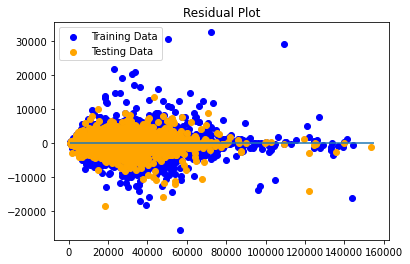

In [54]:
### BEGIN SOLUTION
predictions = randomized_mse.predict(X_test)
plt.scatter(randomized_mse.predict(X_train), randomized_mse.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(randomized_mse.predict(X_test), randomized_mse.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION